  SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO

CARACTERÍSTICAS DEL SISTEMA:
✓ Análisis visual en tiempo real con MediaPipe
✓ Simulación de 11 sensores IMU distribuidos
✓ Cálculo automático de métricas biomecánicas
✓ Visualización gráfica en tiempo real
✓ Exportación de datos para análisis posterior

REQUISITOS TÉCNICOS:
- Cámara web conectada
- Python 3.8+ con librerías: opencv, mediapipe, tkinter
- Iluminación adecuada para detección de pose

Iniciando interfaz gráfica...
------------------------------------------------------------


2025-08-12 16:12:48,862 - INFO - Cámara inicializada: 1280x720 @ 30.0 FPS
2025-08-12 16:12:50,460 - INFO - Grabación visual iniciada
2025-08-12 16:12:50,462 - INFO - Simulación IMU iniciada
2025-08-12 16:12:57,793 - INFO - Grabación visual detenida
2025-08-12 16:12:57,804 - INFO - Simulación IMU detenida
2025-08-12 16:13:09,125 - INFO - Grabación visual iniciada
2025-08-12 16:13:09,134 - INFO - Simulación IMU iniciada
2025-08-12 16:13:14,261 - INFO - Grabación visual detenida
2025-08-12 16:13:14,274 - INFO - Simulación IMU detenida



Sistema finalizado correctamente.


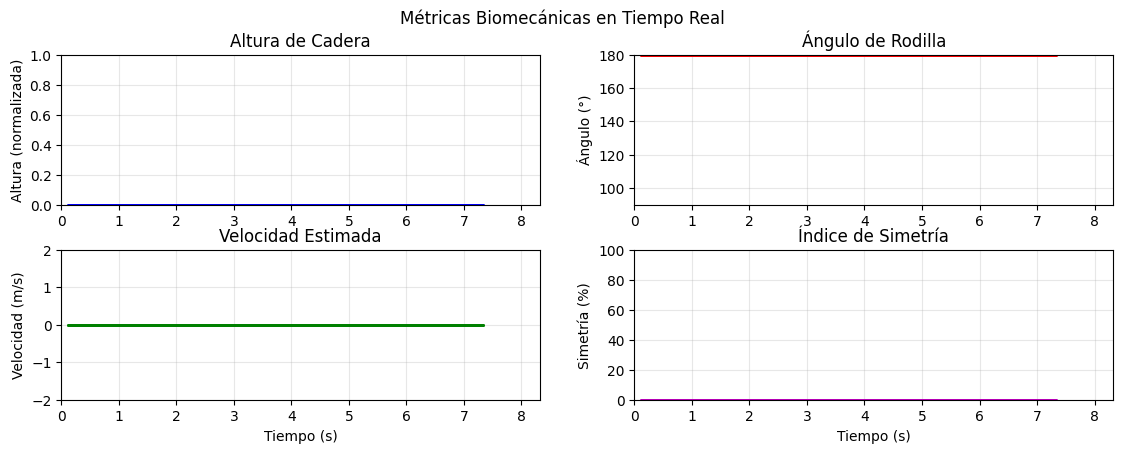

In [1]:
"""
SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO
================================================================

Este sistema implementa una solución híbrida inercial-visual para el análisis 
técnico y físico del salto largo en deportistas. Combina:

1. ANÁLISIS VISUAL: Utiliza MediaPipe para detectar 33 puntos clave del cuerpo humano
2. SIMULACIÓN IMU: Simula 11 sensores inerciales distribuidos estratégicamente
3. ANÁLISIS BIOMECÁNICO: Calcula métricas específicas del salto largo en tiempo real
4. INTERFAZ GRÁFICA: Proporciona visualización y control del sistema

CARACTERÍSTICAS PRINCIPALES:
- Análisis en tiempo real de técnica de salto
- Cálculo de centro de masa corporal
- Medición de ángulos articulares críticos
- Evaluación de simetría bilateral
- Exportación de datos para análisis posterior

REQUISITOS TÉCNICOS:
- Python 3.8+
- OpenCV para captura de video
- MediaPipe para análisis postural
- Tkinter para interfaz gráfica
- Matplotlib para gráficos en tiempo real

Autor: Daniel Andres Ramirez Segura
Versión: 1.0
Fecha: Agosto 2025
"""

import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import threading
import queue
import time
from datetime import datetime
import json
import math
from collections import deque
import logging
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# CONFIGURACIÓN DEL SISTEMA DE LOGGING
# =============================================================================
# Configura el sistema de registro de eventos para debugging y monitoreo
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# =============================================================================
# CLASE PRINCIPAL: ADQUISICIÓN DE DATOS VISUALES
# =============================================================================
class AdquisicionDataCamara:
    """
    CLASE PARA ADQUISICIÓN Y PROCESAMIENTO DE DATOS VISUALES
    
    Esta clase es el núcleo del análisis visual del sistema. Se encarga de:
    - Capturar video desde la cámara del computador
    - Procesar cada frame con MediaPipe para detectar poses humanas
    - Calcular métricas biomecánicas específicas del salto largo
    - Almacenar datos en buffers circulares para análisis en tiempo real
    
    FUNCIONAMIENTO:
    1. Inicializa la cámara con resolución y FPS específicos
    2. Cada frame capturado se procesa con MediaPipe
    3. Se extraen 33 puntos clave del cuerpo humano
    4. Se calculan métricas biomecánicas derivadas
    5. Los datos se almacenan para análisis posterior
    """
    
    def __init__(self, camera_id=0, fps=30, resolution=(1280, 720)):
        """
        INICIALIZACIÓN DEL SISTEMA DE CÁMARA
        
        Parámetros:
        - camera_id: ID de la cámara (0 = cámara por defecto)
        - fps: Frames por segundo deseados
        - resolution: Resolución de captura (ancho, alto)
        """
        self.camera_id = camera_id
        self.fps = fps
        self.resolution = resolution
        self.is_recording = False  # Flag para controlar grabación
        self.show_preview = True   # Flag para mostrar preview visual
        
        # =============================================================
        # INICIALIZACIÓN DE MEDIAPIPE
        # =============================================================
        # MediaPipe es la tecnología de Google para detección de poses humanas
        self.mp_pose = mp.solutions.pose
        self.mp_drawing = mp.solutions.drawing_utils
        
        # Configuración optimizada de MediaPipe para salto largo
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,        # Modo video (no imagen estática)
            model_complexity=2,             # Máxima precisión (0=ligero, 2=preciso)
            enable_segmentation=False,      # No necesitamos segmentación de fondo
            min_detection_confidence=0.7,   # Confianza mínima para detectar persona
            min_tracking_confidence=0.8     # Confianza mínima para seguimiento
        )
        
        # =============================================================
        # BUFFERS DE DATOS
        # =============================================================
        # Utilizamos deques (colas dobles) para almacenamiento eficiente
        self.visual_data_buffer = deque(maxlen=10000)  # Datos biomecánicos
        self.frame_buffer = deque(maxlen=100)          # Frames para preview
        
        # Inicializar la cámara
        self.iniciar_camara()
    
    def iniciar_camara(self):
        """
        INICIALIZACIÓN DE LA CÁMARA DE VIDEO
        
        Esta función configura la cámara con los parámetros especificados
        y verifica que la configuración sea exitosa.
        """
        try:
            # Crear objeto de captura de video
            self.cap = cv2.VideoCapture(self.camera_id)
            
            # Verificar que la cámara se abrió correctamente
            if not self.cap.isOpened():
                raise Exception(f"No se puede abrir la cámara {self.camera_id}")
            
            # ==========================================================
            # CONFIGURACIÓN DE PARÁMETROS DE CÁMARA
            # ==========================================================
            self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.resolution[0])   # Ancho
            self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.resolution[1])  # Alto
            self.cap.set(cv2.CAP_PROP_FPS, self.fps)                     # FPS
            self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)                     # Buffer mínimo
            
            # Verificar configuración real (puede diferir de lo solicitado)
            actual_fps = self.cap.get(cv2.CAP_PROP_FPS)
            actual_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            actual_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            
            logger.info(f"Cámara inicializada: {actual_width}x{actual_height} @ {actual_fps} FPS")
            
        except Exception as e:
            logger.error(f"Error inicializando cámara: {e}")
            raise
    
    def procesar_frame_mediapipe(self, frame):
        """
        PROCESAMIENTO DE FRAME CON MEDIAPIPE
        
        Esta es la función más importante del análisis visual.
        Toma un frame de video y extrae toda la información biomecánica.
        
        Proceso:
        1. Convierte frame de BGR a RGB (formato requerido por MediaPipe)
        2. Detecta pose humana con MediaPipe
        3. Extrae coordenadas de 33 puntos clave
        4. Calcula métricas biomecánicas derivadas
        5. Evalúa calidad de la detección
        
        Retorna: Diccionario con todas las métricas calculadas
        """
        # Conversión de formato de color para MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # PROCESAMIENTO CON MEDIAPIPE
        results = self.pose.process(rgb_frame)
        
        # Inicializar contenedores de datos
        landmarks_data = {}     # Coordenadas de puntos clave
        quality_metrics = {}    # Métricas de calidad
        
        # =============================================================
        # PROCESAMIENTO SI SE DETECTÓ UNA POSE
        # =============================================================
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            
            # =========================================================
            # EXTRACCIÓN DE COORDENADAS DE 33 PUNTOS CLAVE
            # =========================================================
            # MediaPipe detecta 33 puntos específicos del cuerpo:
            # 0: nariz, 1-4: ojos, 5-6: orejas, 7-10: boca
            # 11-16: brazos, 17-22: manos, 23-28: piernas, 29-32: pies
            for idx, landmark in enumerate(landmarks):
                landmarks_data[f'landmark_{idx}_x'] = landmark.x           # Coordenada X (normalizada 0-1)
                landmarks_data[f'landmark_{idx}_y'] = landmark.y           # Coordenada Y (normalizada 0-1)
                landmarks_data[f'landmark_{idx}_z'] = landmark.z           # Profundidad estimada
                landmarks_data[f'landmark_{idx}_visibility'] = landmark.visibility  # Confianza del punto
            
            # =========================================================
            # CÁLCULO DE MÉTRICAS BIOMECÁNICAS
            # =========================================================
            bio_metrics = self.calcular_metricas_biomecanicas(landmarks)
            landmarks_data.update(bio_metrics)
            
            # =========================================================
            # EVALUACIÓN DE CALIDAD DE DETECCIÓN
            # =========================================================
            quality_metrics = self.calcular__metricas_de_calidad(landmarks)
            landmarks_data.update(quality_metrics)
            
            # =========================================================
            # VISUALIZACIÓN PARA PREVIEW (OPCIONAL)
            # =========================================================
            if self.show_preview:
                annotated_frame = frame.copy()
                # Dibujar esqueleto sobre la imagen
                self.mp_drawing.draw_landmarks(
                    annotated_frame, 
                    results.pose_landmarks, 
                    self.mp_pose.POSE_CONNECTIONS
                )
                self.frame_buffer.append(annotated_frame)
        
        # =============================================================
        # MANEJO CUANDO NO SE DETECTA POSE
        # =============================================================
        else:
            # Rellenar con valores NaN (Not a Number) para mantener estructura
            for idx in range(33):
                landmarks_data[f'landmark_{idx}_x'] = np.nan
                landmarks_data[f'landmark_{idx}_y'] = np.nan
                landmarks_data[f'landmark_{idx}_z'] = np.nan
                landmarks_data[f'landmark_{idx}_visibility'] = 0.0
            
            # Indicar que no hubo detección
            quality_metrics['detection_confidence'] = 0.0
            landmarks_data.update(quality_metrics)
            
            # Almacenar frame sin anotaciones
            if self.show_preview:
                self.frame_buffer.append(frame)
        
        return landmarks_data
    
    def calcular_metricas_biomecanicas(self, landmarks):
        """
        CÁLCULO DE MÉTRICAS BIOMECÁNICAS ESPECÍFICAS DEL SALTO LARGO
        
        Esta función calcula las métricas más importantes para evaluar
        la técnica del salto largo:
        
        MÉTRICAS CALCULADAS:
        1. Centro de masa corporal (using segmental weights)
        2. Ángulos articulares (rodillas, caderas)
        3. Ángulo del tronco respecto a la vertical
        4. Altura relativa de las caderas
        5. Índice de simetría bilateral
        6. Velocidad estimada del centro de masa
        7. Validación de proporciones anatómicas
        8. Validación de rangos de ángulos
        Estas métricas son fundamentales para evaluar la técnica del atleta
        """
        metrics = {}
        
        try:
            # ==========================================================
            # 1. CENTRO DE MASA CORPORAL
            # ==========================================================
            # El centro de masa es crítico para analizar la trayectoria del salto
            com_x, com_y = self.calcular_centro_de_masa(landmarks)
            metrics['center_of_mass_x'] = com_x
            metrics['center_of_mass_y'] = com_y
            
            # ==========================================================
            # 2. ÁNGULOS ARTICULARES CRÍTICOS
            # ==========================================================
            
            # ÁNGULO DE RODILLA DERECHA (cadera-rodilla-tobillo)
            # Importante para evaluar flexión durante despegue y aterrizaje
            knee_angle_r = self.calcular_angulo_articular(
                landmarks[24], landmarks[26], landmarks[28]  # cadera-rodilla-tobillo derecho
            )
            metrics['knee_angle_right'] = knee_angle_r
            
            # ÁNGULO DE RODILLA IZQUIERDA
            knee_angle_l = self.calcular_angulo_articular(
                landmarks[23], landmarks[25], landmarks[27]  # cadera-rodilla-tobillo izquierdo
            )
            metrics['knee_angle_left'] = knee_angle_l
            
            # ==========================================================
            # 3. ÁNGULO DEL TRONCO
            # ==========================================================
            # El ángulo del tronco es crítico durante la aproximación y despegue
            trunk_angle = self.calcular_angulo_tronco(landmarks)
            metrics['trunk_angle'] = trunk_angle
            
            # ==========================================================
            # 4. ALTURA RELATIVA DE CADERAS
            # ==========================================================
            # Indica la altura del centro de masa durante el movimiento
            hip_height = (landmarks[23].y + landmarks[24].y) / 2
            metrics['hip_height'] = 1.0 - hip_height  # Invertir coordenadas Y
            
            # ==========================================================
            # 5. SIMETRÍA BILATERAL
            # ==========================================================
            # Evalúa si el atleta mantiene simetría entre lado izquierdo y derecho
            symmetry_index = self.calcular_simetria_bilateral(landmarks)
            metrics['symmetry_index'] = symmetry_index
            
            # ==========================================================
            # 6. VELOCIDAD ESTIMADA
            # ==========================================================
            # Calcula velocidad basándose en el cambio de posición del centro de masa
            if len(self.visual_data_buffer) > 0:
                prev_com_x = self.visual_data_buffer[-1].get('center_of_mass_x', com_x)
                time_delta = 1.0 / self.fps
                velocity_x = (com_x - prev_com_x) / time_delta if time_delta > 0 else 0
                metrics['velocity_x_estimated'] = velocity_x
            else:
                metrics['velocity_x_estimated'] = 0.0

            # ==========================================================
            # 7. Validación de proporciones anatómicas
            # ==========================================================            
            proportion_metrics = self.validar_proporciones_anatomicas(landmarks)
            metrics.update(proportion_metrics)
            # ==========================================================
            # 8. Validación de rangos de ángulos
            # ==========================================================            
            angle_validation = self.validar_rangos_angulos_articulaciones(landmarks)
            metrics.update(angle_validation)                
                
        except Exception as e:
            logger.warning(f"Error calculando métricas biomecánicas: {e}")
            
        return metrics
    
    def calcular_centro_de_masa(self, landmarks):
        """
        CÁLCULO DEL CENTRO DE MASA USANDO MODELO DE PESOS SEGMENTALES
        
        Este cálculo se basa en investigación biomecánica que determina
        qué porcentaje de la masa corporal total representa cada segmento:
        
        DISTRIBUCIÓN DE MASA CORPORAL:
        - Cabeza: 8% del peso corporal
        - Tronco: 50% del peso corporal  
        - Brazos: 10% del peso corporal
        - Muslos: 20% del peso corporal
        - Piernas: 12% del peso corporal
        
        Esta distribución permite calcular el centro de masa real del cuerpo
        """
        # Pesos segmentales basados en literatura biomecánica
        segment_weights = {
            'head': 0.08,      # 8% - Cabeza
            'trunk': 0.50,     # 50% - Tronco (torso)
            'arms': 0.10,      # 10% - Brazos
            'thighs': 0.20,    # 20% - Muslos
            'shanks': 0.12     # 12% - Piernas (desde rodilla)
        }
        
        # =============================================================
        # CÁLCULO DE POSICIONES SEGMENTALES
        # =============================================================
        
        # CABEZA: punto de la nariz
        head_x, head_y = landmarks[0].x, landmarks[0].y
        
        # TRONCO: promedio de hombros y caderas
        trunk_x = (landmarks[11].x + landmarks[12].x + landmarks[23].x + landmarks[24].x) / 4
        trunk_y = (landmarks[11].y + landmarks[12].y + landmarks[23].y + landmarks[24].y) / 4
        
        # BRAZOS: promedio de codos y muñecas
        arms_x = (landmarks[13].x + landmarks[14].x + landmarks[15].x + landmarks[16].x) / 4
        arms_y = (landmarks[13].y + landmarks[14].y + landmarks[15].y + landmarks[16].y) / 4
        
        # MUSLOS: promedio de rodillas
        thighs_x = (landmarks[25].x + landmarks[26].x) / 2
        thighs_y = (landmarks[25].y + landmarks[26].y) / 2
        
        # PIERNAS: promedio de tobillos
        shanks_x = (landmarks[27].x + landmarks[28].x) / 2
        shanks_y = (landmarks[27].y + landmarks[28].y) / 2
        
        # =============================================================
        # CÁLCULO DEL CENTRO DE MASA PONDERADO
        # =============================================================
        com_x = (segment_weights['head'] * head_x +
                segment_weights['trunk'] * trunk_x +
                segment_weights['arms'] * arms_x +
                segment_weights['thighs'] * thighs_x +
                segment_weights['shanks'] * shanks_x)
        
        com_y = (segment_weights['head'] * head_y +
                segment_weights['trunk'] * trunk_y +
                segment_weights['arms'] * arms_y +
                segment_weights['thighs'] * thighs_y +
                segment_weights['shanks'] * shanks_y)
        
        return com_x, com_y
    
    def calcular_angulo_articular(self, point1, point2, point3):
        """
        CÁLCULO DE ÁNGULO ARTICULAR ENTRE TRES PUNTOS
        
        Esta función calcula el ángulo formado por tres puntos, donde:
        - point1: punto proximal (ej: cadera)
        - point2: punto de articulación (ej: rodilla) - VÉRTICE DEL ÁNGULO
        - point3: punto distal (ej: tobillo)
        
        El cálculo usa el producto punto de vectores y trigonometría
        para determinar el ángulo en grados.
        
        EJEMPLO: Para ángulo de rodilla
        - point1 = cadera
        - point2 = rodilla (vértice)
        - point3 = tobillo
        """
        try:
            # Convertir puntos a arrays de numpy para cálculos vectoriales
            a = np.array([point1.x, point1.y])
            b = np.array([point2.x, point2.y])  # Vértice del ángulo
            c = np.array([point3.x, point3.y])
            
            # Calcular vectores desde el vértice hacia los otros puntos
            ba = a - b  # Vector de rodilla hacia cadera
            bc = c - b  # Vector de rodilla hacia tobillo
            
            # Calcular ángulo usando producto punto
            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
            
            # Limitar valor para evitar errores numéricos en arccos
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            
            # Convertir a ángulo en grados
            angle = np.arccos(cosine_angle)
            return np.degrees(angle)
            
        except:
            return np.nan  # Retornar NaN si hay error en el cálculo
    
    def calcular_angulo_tronco(self, landmarks):
        """
        CÁLCULO DEL ÁNGULO DEL TRONCO RESPECTO A LA VERTICAL
        
        Este ángulo es crítico para evaluar la postura durante:
        - Fase de aproximación (debería ser ligeramente inclinado hacia adelante)
        - Momento del despegue (postura más erguida)
        - Fase de vuelo (puede variar según técnica)
        
        El ángulo se calcula entre el vector del tronco y la vertical
        """
        try:
            # Calcular punto medio de los hombros
            shoulder_mid_x = (landmarks[11].x + landmarks[12].x) / 2
            shoulder_mid_y = (landmarks[11].y + landmarks[12].y) / 2
            
            # Calcular punto medio de las caderas
            hip_mid_x = (landmarks[23].x + landmarks[24].x) / 2
            hip_mid_y = (landmarks[23].y + landmarks[24].y) / 2
            
            # Vector del tronco (de caderas hacia hombros)
            trunk_vector = np.array([hip_mid_x - shoulder_mid_x, hip_mid_y - shoulder_mid_y])
            
            # Vector vertical de referencia (hacia abajo en coordenadas de imagen)
            vertical_vector = np.array([0, 1])
            
            # Calcular ángulo entre tronco y vertical
            cosine_angle = np.dot(trunk_vector, vertical_vector) / (
                np.linalg.norm(trunk_vector) * np.linalg.norm(vertical_vector)
            )
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            angle = np.arccos(cosine_angle)
            
            return np.degrees(angle)
        except:
            return np.nan
    
    def calcular_simetria_bilateral(self, landmarks):
        """
        CÁLCULO DEL ÍNDICE DE SIMETRÍA BILATERAL
        
        La simetría bilateral es importante para:
        - Detectar posibles lesiones o compensaciones
        - Evaluar equilibrio técnico
        - Identificar dominancia lateral excesiva
        
        Se calcula comparando las posiciones de extremidades izquierda vs derecha
        Retorna un valor de 0-100% (100% = perfecta simetría)
        """
        try:
            # Comparar alturas de rodillas izquierda vs derecha
            left_knee_y = landmarks[25].y   # Rodilla izquierda
            right_knee_y = landmarks[26].y  # Rodilla derecha
            
            # Comparar alturas de tobillos izquierda vs derecha
            left_ankle_y = landmarks[27].y   # Tobillo izquierdo
            right_ankle_y = landmarks[28].y  # Tobillo derecho
            
            # Calcular diferencias absolutas
            knee_diff = abs(left_knee_y - right_knee_y)
            ankle_diff = abs(left_ankle_y - right_ankle_y)
            
            # Calcular índice de simetría (menor diferencia = mayor simetría)
            symmetry = 100 * (1 - (knee_diff + ankle_diff) / 2)
            
            # Asegurar que el valor esté entre 0 y 100
            return max(0, symmetry)
        except:
            return 0.0
    
    def calcular__metricas_de_calidad(self, landmarks):
        """
        CÁLCULO DE MÉTRICAS DE CALIDAD DE LA DETECCIÓN
        
        Estas métricas nos ayudan a evaluar qué tan confiable es la detección:
        - detection_confidence: Confianza promedio de los puntos clave
        - detection_completeness: Porcentaje de puntos detectados correctamente
        - valid_landmarks: Número de puntos con alta confianza
        
        Esto es crucial para filtrar datos de mala calidad
        """
        try:
            # Seleccionar puntos clave más importantes para salto largo
            key_landmarks = [11, 12, 13, 14, 23, 24, 25, 26, 27, 28]  # Brazos y piernas
            
            # Extraer valores de confianza (visibility) de estos puntos
            confidences = [landmarks[i].visibility for i in key_landmarks]
            
            # Calcular confianza promedio
            avg_confidence = np.mean(confidences)
            
            # Contar puntos con alta confianza (>0.5)
            valid_landmarks = sum(1 for conf in confidences if conf > 0.5)
            
            # Calcular completitud como porcentaje
            completeness = valid_landmarks / len(key_landmarks)
            
            return {
                'detection_confidence': avg_confidence,      # 0.0 - 1.0
                'detection_completeness': completeness,      # 0.0 - 1.0
                'valid_landmarks': valid_landmarks           # Número entero
            }
        except:
            return {
                'detection_confidence': 0.0,
                'detection_completeness': 0.0,
                'valid_landmarks': 0
            }
    
    def capturar_datos_visuales(self):
        """
        FUNCIÓN PRINCIPAL DE CAPTURA DE DATOS VISUALES
        
        Esta función se ejecuta en un hilo separado durante la grabación.
        Realiza un bucle continuo que:
        1. Captura frame de la cámara
        2. Procesa el frame con MediaPipe
        3. Calcula métricas biomecánicas
        4. Almacena los datos en buffer
        5. Controla la frecuencia de captura
        
        Es el corazón del sistema de análisis visual.
        """
        frame_count = 0
        start_time = time.time()
        
        # BUCLE PRINCIPAL DE CAPTURA
        while self.is_recording:
            # Capturar frame de la cámara
            ret, frame = self.cap.read()
            
            if ret:  # Si la captura fue exitosa
                timestamp = time.time()
                
                # =====================================================
                # PROCESAMIENTO DEL FRAME
                # =====================================================
                landmarks_data = self.procesar_frame_mediapipe(frame)
                
                # =====================================================
                # CREAR MUESTRA DE DATOS COMPLETA
                # =====================================================
                visual_sample = {
                    'timestamp': timestamp,                    # Timestamp absoluto
                    'frame_number': frame_count,               # Número de frame
                    'elapsed_time': timestamp - start_time,    # Tiempo transcurrido
                    **landmarks_data                           # Todas las métricas calculadas
                }
                
                # Almacenar en buffer circular
                self.visual_data_buffer.append(visual_sample)
                frame_count += 1
                
                # =====================================================
                # CONTROL DE FRECUENCIA
                # =====================================================
                # Calcular cuándo debería capturarse el siguiente frame
                expected_time = start_time + (frame_count / self.fps)
                current_time = time.time()
                sleep_time = expected_time - current_time
                
                # Dormir si vamos muy rápido (control de FPS)
                if sleep_time > 0:
                    time.sleep(sleep_time)
            else:
                logger.warning("No se pudo capturar frame de la cámara")
                time.sleep(0.1)  # Pausa breve antes de reintentar
    
    def obtener_ultimo_frame(self):
        """Retorna el último frame capturado para preview en la interfaz"""
        if self.frame_buffer:
            return self.frame_buffer[-1]
        return None
    
    def comenzar_grabacion(self):
        """Inicia la grabación de datos visuales en hilo separado"""
        self.is_recording = True
        self.hilo_visual = threading.Thread(target=self.capturar_datos_visuales, daemon=True)
        self.hilo_visual.start()
        logger.info("Grabación visual iniciada")
    
    def detener_grabacion(self):
        """Detiene la grabación y espera a que termine el hilo"""
        self.is_recording = False
        if hasattr(self, 'hilo_visual'):
            self.hilo_visual.join(timeout=2)
        logger.info("Grabación visual detenida")
    
    def obtener_datos_visuales(self):
        """Retorna todos los datos visuales capturados"""
        return list(self.visual_data_buffer)
    
    def __del__(self):
        """Destructor: libera recursos de cámara automáticamente"""
        if hasattr(self, 'cap'):
            self.cap.release()

    # Funciones adicionales de Validación para entender si los pronosticos si están bien parametrizados:
    def validar_proporciones_anatomicas(self, landmarks):
        """
        VALIDACIÓN DE PROPORCIONES ANATÓMICAS
        Verifica que las proporciones corporales sean realistas
        """
        try:
            # Calcular distancias clave
            # Distancia hombro-cadera (tronco)
            shoulder_mid_x = (landmarks[11].x + landmarks[12].x) / 2
            shoulder_mid_y = (landmarks[11].y + landmarks[12].y) / 2
            hip_mid_x = (landmarks[23].x + landmarks[24].x) / 2
            hip_mid_y = (landmarks[23].y + landmarks[24].y) / 2

            torso_length = np.sqrt((shoulder_mid_x - hip_mid_x)**2 + (shoulder_mid_y - hip_mid_y)**2)

            # Distancia cadera-tobillo (pierna)
            ankle_mid_x = (landmarks[27].x + landmarks[28].x) / 2
            ankle_mid_y = (landmarks[27].y + landmarks[28].y) / 2

            leg_length = np.sqrt((hip_mid_x - ankle_mid_x)**2 + (hip_mid_y - ankle_mid_y)**2)

            # Ratio pierna/tronco (normal: 1.0 - 1.3)
            if torso_length > 0:
                leg_torso_ratio = leg_length / torso_length
                proportion_valid = 0.8 <= leg_torso_ratio <= 1.5
            else:
                proportion_valid = False
                leg_torso_ratio = 0

            return {
                'leg_torso_ratio': leg_torso_ratio,
                'proportion_valid': proportion_valid,
                'torso_length': torso_length,
                'leg_length': leg_length
            }
        except:
            return {
                'leg_torso_ratio': 0,
                'proportion_valid': False,
                'torso_length': 0,
                'leg_length': 0
            }

    def validar_rangos_angulos_articulaciones(self, landmarks):
        """
        VALIDACIÓN DE RANGOS ANATÓMICOS DE ÁNGULOS
        Verifica que los ángulos estén en rangos humanamente posibles
        """
        try:
            # Ángulos ya calculados
            knee_angle_r = self.calcular_angulo_articular(landmarks[24], landmarks[26], landmarks[28])
            knee_angle_l = self.calcular_angulo_articular(landmarks[23], landmarks[25], landmarks[27])

            # Ángulo de cadera derecha (tronco-muslo-rodilla)
            hip_angle_r = self.calcular_angulo_articular(landmarks[12], landmarks[24], landmarks[26])

            # Rangos anatómicos válidos (en grados)
            angle_ranges = {
                'knee': (80, 180),    # Rodilla: flexión completa a extensión
                'hip': (60, 180)      # Cadera: flexión profunda a extensión
            }

            # Validaciones
            knee_r_valid = angle_ranges['knee'][0] <= knee_angle_r <= angle_ranges['knee'][1]
            knee_l_valid = angle_ranges['knee'][0] <= knee_angle_l <= angle_ranges['knee'][1]
            hip_r_valid = angle_ranges['hip'][0] <= hip_angle_r <= angle_ranges['hip'][1]

            # Simetría bilateral (diferencia < 20°)
            knee_symmetry = abs(knee_angle_r - knee_angle_l) < 20

            return {
                'knee_right_valid': knee_r_valid,
                'knee_left_valid': knee_l_valid,
                'hip_right_valid': hip_r_valid,
                'knee_bilateral_symmetry': knee_symmetry,
                'hip_angle_right': hip_angle_r,
                'angle_validation_score': sum([knee_r_valid, knee_l_valid, hip_r_valid, knee_symmetry]) / 4
            }
        except:
            return {
                'knee_right_valid': False,
                'knee_left_valid': False,
                'hip_right_valid': False,
                'knee_bilateral_symmetry': False,
                'hip_angle_right': 0,
                'angle_validation_score': 0
            }

    def calcular_estabilidad_temporal(self):
        """
        CÁLCULO DE ESTABILIDAD TEMPORAL
        Evalúa la consistencia de las mediciones en el tiempo
        """
        if len(self.visual_data_buffer) < 5:
            return {'temporal_stability': 0, 'fps_stability': 0}

        recent_data = list(self.visual_data_buffer)[-10:]  # Últimas 10 muestras

        try:
            # Estabilidad de FPS
            timestamps = [sample['timestamp'] for sample in recent_data]
            intervals = np.diff(timestamps)
            target_interval = 1.0 / self.fps

            if len(intervals) > 0:
                interval_cv = np.std(intervals) / np.mean(intervals)
                fps_stability = max(0, 1 - interval_cv)
            else:
                fps_stability = 0

            # Estabilidad de detección (variación de confianza)
            confidences = [sample.get('detection_confidence', 0) for sample in recent_data]
            if len(confidences) > 1:
                confidence_stability = 1 - (np.std(confidences) / max(np.mean(confidences), 0.1))
                confidence_stability = max(0, confidence_stability)
            else:
                confidence_stability = 0

            # Suavidad de centro de masa
            com_x_values = [sample.get('center_of_mass_x', 0) for sample in recent_data 
                           if not np.isnan(sample.get('center_of_mass_x', np.nan))]
            if len(com_x_values) > 2:
                com_acceleration = np.diff(com_x_values, n=2)
                com_smoothness = 1 / (1 + np.std(com_acceleration))
            else:
                com_smoothness = 0

            temporal_stability = (fps_stability + confidence_stability + com_smoothness) / 3

            return {
                'temporal_stability': temporal_stability,
                'fps_stability': fps_stability,
                'confidence_stability': confidence_stability,
                'com_smoothness': com_smoothness
            }
        except:
            return {'temporal_stability': 0, 'fps_stability': 0, 'confidence_stability': 0, 'com_smoothness': 0}

    def calcular_confiabilidad(self):
        """
        CÁLCULO DE FIABILIDAD GLOBAL
        Combina todas las métricas en un índice único
        """
        if len(self.visual_data_buffer) == 0:
            return {'reliability_index': 0, 'classification': 'NO_DATA', 'details': {}}

        recent_data = list(self.visual_data_buffer)[-20:]  # Últimas 20 muestras

        # Recopilar métricas
        detection_scores = []
        validation_scores = []
        temporal_scores = []

        for sample in recent_data:
            # Métricas de detección
            detection_scores.append(sample.get('detection_confidence', 0))

            # Métricas de validación (si están disponibles)
            validation_scores.append(sample.get('angle_validation_score', 0))

        # Calcular estabilidad temporal
        temporal_metrics = self.calcular_estabilidad_temporal()

        # Promedios
        avg_detection = np.mean(detection_scores) if detection_scores else 0
        avg_validation = np.mean(validation_scores) if validation_scores else 0
        avg_temporal = temporal_metrics['temporal_stability']

        # Pesos para cada componente
        weights = {
            'detection_quality': 0.4,      # 40% - Calidad de detección
            'biomechanical_validity': 0.3,  # 30% - Validez biomecánica
            'temporal_consistency': 0.3     # 30% - Consistencia temporal
        }

        # Índice ponderado
        reliability_index = (
            weights['detection_quality'] * avg_detection +
            weights['biomechanical_validity'] * avg_validation +
            weights['temporal_consistency'] * avg_temporal
        )

        # Clasificación
        if reliability_index > 0.9:
            classification = "EXCELENTE"
        elif reliability_index > 0.8:
            classification = "BUENO"
        elif reliability_index > 0.7:
            classification = "ACEPTABLE"
        elif reliability_index > 0.6:
            classification = "REGULAR"
        else:
            classification = "INSUFICIENTE"

        return {
            'reliability_index': reliability_index,
            'classification': classification,
            'details': {
                'detection_quality': avg_detection,
                'biomechanical_validity': avg_validation,
                'temporal_consistency': avg_temporal,
                'sample_count': len(recent_data)
            }
        }


# =============================================================================
# CLASE DE SIMULACIÓN DE SENSORES IMU
# =============================================================================
class Simulador_IMU:
    """
    SIMULADOR DE SENSORES INERCIALES (IMU) PARA DESARROLLO
    
    Esta clase simula el comportamiento de 11 sensores ICM-20948 distribuidos
    estratégicamente en el cuerpo del atleta. La simulación se basa en:
    
    FUNCIONAMIENTO:
    1. Recibe datos del análisis visual (poses, movimientos)
    2. Simula señales de acelerómetro, giroscopio y magnetómetro
    3. Añade ruido realista según la ubicación del sensor
    4. Genera datos a alta frecuencia (1000 Hz) vs video (30 Hz)
    
    PROPÓSITO:
    - Permitir desarrollo sin hardware real
    - Generar datos sintéticos para entrenamiento de modelos
    - Validar algoritmos de fusión sensorial
    - Demostrar capacidades del sistema completo
    
    UBICACIÓN DE LOS 11 SENSORES SIMULADOS:
    0: Cabeza - movimiento suave, poca aceleración
    1-2: Brazos - movimiento moderado durante técnica de vuelo
    3-4: Antebrazos - movimiento más dinámico
    5: Pecho - representa tronco, movimiento central
    6: Lumbar - centro de masa, señal crítica
    7-8: Muslos - alta aceleración durante despegue
    9-10: Tobillos - máxima aceleración durante contacto con suelo
    """
    
    def __init__(self, num_sensors=11, sample_rate=1000):
        """
        INICIALIZACIÓN DEL SIMULADOR IMU
        
        Parámetros:
        - num_sensors: Número de sensores a simular (11 por defecto)
        - sample_rate: Frecuencia de muestreo en Hz (1000 Hz = 1 muestra/ms)
        """
        self.num_sensors = num_sensors
        self.sample_rate = sample_rate
        self.is_recording = False  # Flag de control de grabación
        
        # Buffer circular para almacenar datos IMU simulados
        # Capacidad para ~50 segundos a 1000 Hz
        self.imu_data_buffer = deque(maxlen=50000)
        
        # =============================================================
        # CONFIGURACIÓN ESPECÍFICA POR SENSOR
        # =============================================================
        # Cada sensor tiene características específicas según su ubicación:
        # - location: Ubicación anatómica del sensor
        # - noise_level: Nivel de ruido base (menor = más preciso)
        
        self.sensor_config = {
            0: {'location': 'cabeza', 'noise_level': 0.1},        # Movimiento suave
            1: {'location': 'brazo_izq', 'noise_level': 0.3},     # Movimiento moderado
            2: {'location': 'brazo_der', 'noise_level': 0.3},     # Movimiento moderado
            3: {'location': 'antebrazo_izq', 'noise_level': 0.4}, # Más dinámico
            4: {'location': 'antebrazo_der', 'noise_level': 0.4}, # Más dinámico
            5: {'location': 'pecho', 'noise_level': 0.2},         # Centro del tronco
            6: {'location': 'lumbar', 'noise_level': 0.5},        # Centro de masa
            7: {'location': 'muslo_izq', 'noise_level': 0.6},     # Alta aceleración
            8: {'location': 'muslo_der', 'noise_level': 0.6},     # Alta aceleración
            9: {'location': 'tobillo_izq', 'noise_level': 0.8},   # Máxima aceleración
            10: {'location': 'tobillo_der', 'noise_level': 0.8}   # Máxima aceleración
        }
        
        # Variables de estado para la simulación
        self.last_visual_data = None  # Últimos datos visuales recibidos
        self.simulation_time = 0      # Tiempo interno de simulación
    
    def actualizacion_datos_visuales(self, visual_data):
        """
        ACTUALIZACIÓN DEL ESTADO DE SIMULACIÓN
        
        Esta función recibe los datos más recientes del análisis visual
        y actualiza el estado interno del simulador para generar
        señales IMU coherentes con el movimiento observado.
        """
        self.last_visual_data = visual_data
    
    def simular_imu_pose(self, visual_sample):
        """
        SIMULACIÓN DE DATOS IMU BASADA EN POSE VISUAL
        
        Esta es la función central de la simulación. Toma una muestra
        del análisis visual y genera múltiples muestras IMU correspondientes.
        
        PROCESO:
        1. Extrae métricas de movimiento del análisis visual
        2. Calcula cuántas muestras IMU generar por frame de video
        3. Para cada sensor, simula señales realistas
        4. Añade ruido apropiado según la ubicación
        
        La relación típica es ~33 muestras IMU por frame de video
        (1000 Hz IMU / 30 Hz video = 33.3)
        """
        if not visual_sample:
            return []
        
        simulated_samples = []
        base_timestamp = visual_sample.get('timestamp', time.time())
        
        # =============================================================
        # CÁLCULO DE MUESTRAS POR FRAME
        # =============================================================
        # Generar múltiples muestras IMU por cada frame de video
        # para simular la mayor frecuencia de los sensores inerciales
        samples_per_frame = max(1, int(self.sample_rate / 30))  # Asumiendo 30 FPS
        
        # Generar muestras con timestamps incrementales
        for i in range(samples_per_frame):
            timestamp_offset = i * (1.0 / self.sample_rate)
            
            # Generar datos para cada uno de los 11 sensores
            for sensor_id, config in self.sensor_config.items():
                imu_sample = self.generar_datos_sensor(
                    sensor_id, 
                    config, 
                    visual_sample, 
                    base_timestamp + timestamp_offset
                )
                simulated_samples.append(imu_sample)
        
        return simulated_samples
    
    def generar_datos_sensor(self, sensor_id, config, visual_sample, timestamp):
        """
        GENERACIÓN DE DATOS PARA UN SENSOR ESPECÍFICO
        
        Esta función simula las señales de un sensor ICM-20948 real:
        
        SEÑALES SIMULADAS:
        1. ACELERÓMETRO (3 ejes): Mide aceleración lineal en g's
           - accel_x: Aceleración horizontal (dirección de carrera)
           - accel_y: Aceleración vertical (gravedad + salto)
           - accel_z: Aceleración lateral (estabilidad)
        
        2. GIROSCOPIO (3 ejes): Mide velocidad angular en °/s
           - gyro_x, gyro_y, gyro_z: Rotaciones alrededor de cada eje
        
        3. MAGNETÓMETRO (3 ejes): Mide campo magnético en μT
           - mag_x, mag_y, mag_z: Campo magnético terrestre + ruido
        
        La simulación se basa en:
        - Ubicación del sensor en el cuerpo
        - Métricas de movimiento del análisis visual
        - Modelos físicos de movimiento humano
        - Ruido realista según la ubicación
        """
        location = config['location']
        noise_level = config['noise_level']
        
        # =============================================================
        # EXTRACCIÓN DE MÉTRICAS DE MOVIMIENTO
        # =============================================================
        velocity_x = visual_sample.get('velocity_x_estimated', 0.0)  # Velocidad horizontal
        hip_height = visual_sample.get('hip_height', 0.5)            # Altura de caderas
        knee_angle_r = visual_sample.get('knee_angle_right', 180.0)  # Ángulo de rodilla
        trunk_angle = visual_sample.get('trunk_angle', 90.0)         # Ángulo del tronco
        
        # =============================================================
        # SIMULACIÓN DE ACELERÓMETRO POR UBICACIÓN
        # =============================================================
        
        if 'tobillo' in location:
            # TOBILLOS: Mayor aceleración durante contacto con suelo
            # Durante el salto, los tobillos experimentan fuerzas de hasta 8-10g
            base_accel_y = -9.81 + (20 * (1 - hip_height))  # Más fuerza cuando está más bajo
            base_accel_x = velocity_x * 10                   # Proporcional a velocidad
            base_accel_z = np.sin(np.radians(knee_angle_r)) * 5  # Relacionado con flexión
            
        elif 'muslo' in location:
            # MUSLOS: Aceleración relacionada con ángulo de rodilla
            # Los muslos son críticos durante la fase de despegue
            base_accel_y = -9.81 + np.cos(np.radians(knee_angle_r)) * 10
            base_accel_x = velocity_x * 8
            base_accel_z = np.sin(np.radians(trunk_angle)) * 3
            
        elif 'lumbar' in location:
            # LUMBAR: Centro de masa, movimiento más suave
            # Representa el centro de masa corporal total
            base_accel_y = -9.81 + (hip_height - 0.5) * 15
            base_accel_x = velocity_x * 5
            base_accel_z = 0  # Movimiento lateral mínimo
            
        else:
            # OTROS SENSORES: Movimiento moderado (cabeza, brazos)
            base_accel_y = -9.81 + np.random.normal(0, 2)
            base_accel_x = velocity_x * 3
            base_accel_z = np.random.normal(0, 1)
        
        # =============================================================
        # ADICIÓN DE RUIDO REALISTA
        # =============================================================
        # Los sensores reales tienen ruido característico
        noise_x = np.random.normal(0, noise_level)
        noise_y = np.random.normal(0, noise_level)
        noise_z = np.random.normal(0, noise_level)
        
        # =============================================================
        # SIMULACIÓN DE GIROSCOPIO
        # =============================================================
        # Velocidades angulares con ruido proporcional
        gyro_noise = noise_level * 10  # Giroscopio típicamente más ruidoso
        base_gyro_x = np.random.normal(0, gyro_noise)
        base_gyro_y = np.random.normal(0, gyro_noise)
        base_gyro_z = np.random.normal(0, gyro_noise)
        
        # =============================================================
        # SIMULACIÓN DE MAGNETÓMETRO
        # =============================================================
        # Campo magnético terrestre + perturbaciones
        mag_noise = noise_level * 5
        base_mag_x = 20 + np.random.normal(0, mag_noise)   # Componente Norte
        base_mag_y = 40 + np.random.normal(0, mag_noise)   # Componente Este
        base_mag_z = -30 + np.random.normal(0, mag_noise)  # Componente vertical
        
        # =============================================================
        # MUESTRA COMPLETA DEL SENSOR
        # =============================================================
        return {
            'timestamp': timestamp,
            'sensor_id': sensor_id,
            'location': location,
            # Acelerómetro (m/s²)
            'accel_x': base_accel_x + noise_x,
            'accel_y': base_accel_y + noise_y,
            'accel_z': base_accel_z + noise_z,
            # Giroscopio (°/s)
            'gyro_x': base_gyro_x,
            'gyro_y': base_gyro_y,
            'gyro_z': base_gyro_z,
            # Magnetómetro (μT)
            'mag_x': base_mag_x,
            'mag_y': base_mag_y,
            'mag_z': base_mag_z,
            'system_timestamp': timestamp
        }
    
    def simular_datos_imu(self, camera_system):
        """
        HILO PRINCIPAL DE SIMULACIÓN IMU
        
        Esta función se ejecuta en un hilo separado y:
        1. Obtiene datos visuales más recientes
        2. Simula señales IMU correspondientes
        3. Almacena datos en buffer circular
        4. Mantiene frecuencia de 1000 Hz
        
        La simulación es síncrona con el análisis visual
        """
        while self.is_recording:
            # Obtener últimos datos del sistema de cámara
            visual_data = camera_system.obtener_datos_visuales()
            
            if visual_data:
                # Tomar la muestra más reciente
                latest_sample = visual_data[-1]
                
                # Simular datos IMU correspondientes
                simulated_samples = self.simular_imu_pose(latest_sample)
                
                # Almacenar todas las muestras generadas
                for sample in simulated_samples:
                    self.imu_data_buffer.append(sample)
            
            # Control de frecuencia de simulación
            time.sleep(1.0 / self.sample_rate)
    
    def comenzar_grabacion(self, camera_system):
        """Inicia la simulación IMU en hilo separado"""
        self.is_recording = True
        self.camera_system = camera_system
        self.imu_thread = threading.Thread(target=self.simular_datos_imu, args=(camera_system,), daemon=True)
        self.imu_thread.start()
        logger.info("Simulación IMU iniciada")
    
    def detener_grabacion(self):
        """Detiene la simulación IMU"""
        self.is_recording = False
        if hasattr(self, 'imu_thread'):
            self.imu_thread.join(timeout=2)
        logger.info("Simulación IMU detenida")
    
    def obtener_datos_imu(self):
        """Retorna todos los datos IMU simulados"""
        return list(self.imu_data_buffer)

    def validar_coherencia_imu(self):
        """
        VALIDACIÓN DE COHERENCIA ENTRE SENSORES IMU
        Verifica que los sensores simulados sean consistentes entre sí
        """
        if len(self.imu_data_buffer) < 10:
            return {'imu_coherence': 0, 'acceleration_validity': 0}

        recent_samples = list(self.imu_data_buffer)[-50:]  # Últimas 50 muestras

        try:
            # Agrupar por timestamp
            by_timestamp = {}
            for sample in recent_samples:
                ts = round(sample['timestamp'], 3)  # Redondear para agrupar
                if ts not in by_timestamp:
                    by_timestamp[ts] = []
                by_timestamp[ts].append(sample)

            # Validar coherencia bilateral
            coherence_scores = []
            acceleration_violations = 0
            total_samples = 0

            # Límites de aceleración por ubicación
            accel_limits = {
                'tobillo': 25.0,  # g's
                'muslo': 20.0,
                'lumbar': 10.0,
                'brazo': 8.0,
                'cabeza': 5.0
            }

            for timestamp, sensors in by_timestamp.items():
                if len(sensors) >= 2:
                    # Verificar simetría bilateral
                    left_accels = []
                    right_accels = []

                    for sensor in sensors:
                        accel_mag = np.sqrt(sensor['accel_x']**2 + sensor['accel_y']**2 + sensor['accel_z']**2)

                        # Validar límites de aceleración
                        limit = 15.0  # Por defecto
                        for loc, lim in accel_limits.items():
                            if loc in sensor['location']:
                                limit = lim
                                break
                            
                        if accel_mag > limit:
                            acceleration_violations += 1
                        total_samples += 1

                        # Agrupar por lado
                        if 'izq' in sensor['location']:
                            left_accels.append(accel_mag)
                        elif 'der' in sensor['location']:
                            right_accels.append(accel_mag)

                    # Calcular simetría bilateral
                    if left_accels and right_accels:
                        left_avg = np.mean(left_accels)
                        right_avg = np.mean(right_accels)
                        if max(left_avg, right_avg) > 0:
                            symmetry = 1.0 - abs(left_avg - right_avg) / max(left_avg, right_avg)
                            coherence_scores.append(max(0, symmetry))

            # Calcular métricas finales
            imu_coherence = np.mean(coherence_scores) if coherence_scores else 0
            acceleration_validity = 1.0 - (acceleration_violations / max(total_samples, 1))

            return {
                'imu_coherence': imu_coherence,
                'acceleration_validity': acceleration_validity,
                'bilateral_samples': len(coherence_scores)
            }

        except Exception as e:
            logger.warning(f"Error validando coherencia IMU: {e}")
            return {'imu_coherence': 0, 'acceleration_validity': 0}

# =============================================================================
# INTERFAZ GRÁFICA DE USUARIO
# =============================================================================
class Interfaz_Biomecanica:
    """
    INTERFAZ GRÁFICA PRINCIPAL DEL SISTEMA
    
    Esta clase proporciona una interfaz completa para:
    
    FUNCIONALIDADES PRINCIPALES:
    1. Control de grabación (iniciar/detener)
    2. Configuración de sesiones (atleta, tipo, duración)
    3. Visualización en tiempo real de métricas
    4. Gráficos dinámicos de análisis biomecánico
    5. Exportación de datos capturados
    6. Generación de reportes automáticos
    
    COMPONENTES DE LA INTERFAZ:
    - Panel de control: Botones y configuración
    - Panel de estado: Log de actividades del sistema
    - Panel de métricas: Valores numéricos en tiempo real
    - Panel de gráficos: Visualización temporal de métricas
    
    La interfaz está diseñada para ser intuitiva tanto para
    investigadores como para entrenadores deportivos.
    """
    
    def __init__(self):
        """
        INICIALIZACIÓN DE LA INTERFAZ GRÁFICA
        
        Configura todos los componentes visuales y prepara
        el sistema para la interacción del usuario.
        """
        # =============================================================
        # CONFIGURACIÓN DE VENTANA PRINCIPAL
        # =============================================================
        self.root = tk.Tk()
        self.root.title("Sistema de Análisis Biomecánico - Salto Largo")
        self.root.geometry("1200x800")  # Tamaño inicial de ventana
        
        # =============================================================
        # INICIALIZACIÓN DE SISTEMAS
        # =============================================================
        self.camera_system = None     # Sistema de cámara (inicializar después)
        self.imu_simulator = None     # Simulador IMU (inicializar después)
        self.is_recording = False     # Estado de grabación
        
        # =============================================================
        # VARIABLES DE CONFIGURACIÓN DE SESIÓN
        # =============================================================
        # Estas variables almacenan la configuración de cada sesión
        self.athlete_id = tk.StringVar(value="atleta_001")        # ID del atleta
        self.session_type = tk.StringVar(value="entrenamiento")   # Tipo de sesión
        self.recording_duration = tk.IntVar(value=30)             # Duración en segundos
        
        # =============================================================
        # BUFFERS PARA GRÁFICOS EN TIEMPO REAL
        # =============================================================
        # Utilizamos deques para mantener histórico limitado para gráficos
        self.plot_data = {
            'time': deque(maxlen=100),        # Últimos 100 puntos temporales
            'hip_height': deque(maxlen=100),  # Altura de caderas
            'knee_angle': deque(maxlen=100),  # Ángulo de rodilla
            'velocity': deque(maxlen=100),    # Velocidad estimada
            'symmetry': deque(maxlen=100)     # Índice de simetría
        }
        
        # Configurar componentes de la interfaz
        self.setup_ui()      # Crear elementos visuales
        self.setup_plots()   # Configurar gráficos
        
        # Timer para actualizaciones periódicas
        self.update_timer = None
    
    def setup_ui(self):
        """
        CONFIGURACIÓN DE ELEMENTOS DE LA INTERFAZ
        
        Esta función crea todos los paneles, botones, etiquetas
        y campos de entrada de la interfaz gráfica.
        """
        # =============================================================
        # PANEL DE CONTROL PRINCIPAL
        # =============================================================
        control_frame = ttk.LabelFrame(self.root, text="Control de Adquisición", padding="10")
        control_frame.pack(fill="x", padx=10, pady=5)
        
        # CONFIGURACIÓN DE SESIÓN
        config_frame = ttk.Frame(control_frame)
        config_frame.pack(fill="x")
        
        # Campo ID Atleta
        ttk.Label(config_frame, text="ID Atleta:").grid(row=0, column=0, sticky="w", padx=5)
        ttk.Entry(config_frame, textvariable=self.athlete_id, width=15).grid(row=0, column=1, padx=5)
        
        # Selector tipo de sesión
        ttk.Label(config_frame, text="Tipo de Sesión:").grid(row=0, column=2, sticky="w", padx=5)
        session_combo = ttk.Combobox(config_frame, textvariable=self.session_type, width=15)
        session_combo['values'] = ('entrenamiento', 'competencia', 'evaluacion', 'rehabilitacion')
        session_combo.grid(row=0, column=3, padx=5)
        
        # Campo duración
        ttk.Label(config_frame, text="Duración (s):").grid(row=0, column=4, sticky="w", padx=5)
        ttk.Entry(config_frame, textvariable=self.recording_duration, width=10).grid(row=0, column=5, padx=5)
        
        # =============================================================
        # BOTONES DE CONTROL
        # =============================================================
        button_frame = ttk.Frame(control_frame)
        button_frame.pack(fill="x", pady=10)
        
        # Botón inicializar sistema
        self.init_button = ttk.Button(button_frame, text="Inicializar Sistema", command=self.initialize_system)
        self.init_button.pack(side="left", padx=5)
        
        # Botón iniciar grabación (deshabilitado inicialmente)
        self.start_button = ttk.Button(button_frame, text="Iniciar Grabación", command=self.comenzar_grabacion, state="disabled")
        self.start_button.pack(side="left", padx=5)
        
        # Botón detener grabación (deshabilitado inicialmente)
        self.stop_button = ttk.Button(button_frame, text="Detener Grabación", command=self.detener_grabacion, state="disabled")
        self.stop_button.pack(side="left", padx=5)
        
        # Botón exportar datos (deshabilitado inicialmente)
        self.export_button = ttk.Button(button_frame, text="Exportar Datos", command=self.export_data, state="disabled")
        self.export_button.pack(side="left", padx=5)
        
        # =============================================================
        # PANEL DE ESTADO DEL SISTEMA
        # =============================================================
        status_frame = ttk.LabelFrame(self.root, text="Estado del Sistema", padding="10")
        status_frame.pack(fill="x", padx=10, pady=5)
        
        # Área de texto para log de eventos
        self.status_text = tk.Text(status_frame, height=4, wrap="word")
        self.status_text.pack(fill="x")
        
        # =============================================================
        # PANEL DE MÉTRICAS EN TIEMPO REAL
        # =============================================================
        metrics_frame = ttk.LabelFrame(self.root, text="Métricas en Tiempo Real", padding="10")
        metrics_frame.pack(fill="both", expand=True, padx=10, pady=5)
        
        # Variables para mostrar métricas actuales
        self.current_metrics = {
            'hip_height': tk.StringVar(value="--"),            # Altura de caderas
            'knee_angle_r': tk.StringVar(value="--"),          # Ángulo rodilla derecha
            'trunk_angle': tk.StringVar(value="--"),           # Ángulo del tronco
            'velocity': tk.StringVar(value="--"),              # Velocidad estimada
            'symmetry': tk.StringVar(value="--"),              # Simetría bilateral
            'confidence': tk.StringVar(value="--"),            # Confianza de detección
            'reliability': tk.StringVar(value="--"),           # Índice de fiabilidad
            'angle_validity': tk.StringVar(value="--"),        # Validez de ángulos
            'temporal_stability': tk.StringVar(value="--")     # Estabilidad temporal

        }
        
        # Display de métricas en formato de tabla
        metrics_display = ttk.Frame(metrics_frame)
        metrics_display.pack(fill="x")
        
        # Primera fila de métricas
        ttk.Label(metrics_display, text="Altura Cadera:").grid(row=0, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['hip_height']).grid(row=0, column=1)
        
        ttk.Label(metrics_display, text="Ángulo Rodilla:").grid(row=0, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['knee_angle_r']).grid(row=0, column=3)
        
        ttk.Label(metrics_display, text="Ángulo Tronco:").grid(row=0, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['trunk_angle']).grid(row=0, column=5)
        
        # Segunda fila de métricas
        ttk.Label(metrics_display, text="Velocidad Est.:").grid(row=1, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['velocity']).grid(row=1, column=1)
        
        ttk.Label(metrics_display, text="Simetría:").grid(row=1, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['symmetry']).grid(row=1, column=3)
        
        ttk.Label(metrics_display, text="Confianza:").grid(row=1, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['confidence']).grid(row=1, column=5)

        # Tercera fila de métricas - FIABILIDAD
        ttk.Label(metrics_display, text="Fiabilidad:").grid(row=2, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['reliability']).grid(row=2, column=1)

        ttk.Label(metrics_display, text="Validez Ángulos:").grid(row=2, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['angle_validity']).grid(row=2, column=3)

        ttk.Label(metrics_display, text="Estabilidad:").grid(row=2, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['temporal_stability']).grid(row=2, column=5)

        # Frame para contener los gráficos
        self.plot_frame = ttk.Frame(metrics_frame)
        self.plot_frame.pack(fill="both", expand=True, pady=10)
    
    def setup_plots(self):
        """
        CONFIGURACIÓN DE GRÁFICOS EN TIEMPO REAL
        
        Crea 4 subgráficos para visualizar las métricas más importantes:
        1. Altura de cadera: Indica altura del centro de masa
        2. Ángulo de rodilla: Fundamental para análisis técnico
        3. Velocidad estimada: Aproximación de velocidad horizontal
        4. Índice de simetría: Evaluación de equilibrio bilateral
        """
        # Crear figura con 4 subgráficos (2x2)
        self.fig, self.axes = plt.subplots(2, 2, figsize=(10, 6))
        self.fig.suptitle("Métricas Biomecánicas en Tiempo Real")
        
        # =============================================================
        # CONFIGURACIÓN DE CADA SUBGRÁFICO
        # =============================================================
        
        # GRÁFICO 1: Altura de Cadera
        self.axes[0, 0].set_title("Altura de Cadera")
        self.axes[0, 0].set_ylabel("Altura (normalizada)")
        self.line_hip, = self.axes[0, 0].plot([], [], 'b-', linewidth=2)
        
        # GRÁFICO 2: Ángulo de Rodilla
        self.axes[0, 1].set_title("Ángulo de Rodilla")
        self.axes[0, 1].set_ylabel("Ángulo (°)")
        self.line_knee, = self.axes[0, 1].plot([], [], 'r-', linewidth=2)
        
        # GRÁFICO 3: Velocidad Estimada
        self.axes[1, 0].set_title("Velocidad Estimada")
        self.axes[1, 0].set_ylabel("Velocidad (m/s)")
        self.axes[1, 0].set_xlabel("Tiempo (s)")
        self.line_velocity, = self.axes[1, 0].plot([], [], 'g-', linewidth=2)
        
        # GRÁFICO 4: Índice de Simetría
        self.axes[1, 1].set_title("Índice de Simetría")
        self.axes[1, 1].set_ylabel("Simetría (%)")
        self.axes[1, 1].set_xlabel("Tiempo (s)")
        self.line_symmetry, = self.axes[1, 1].plot([], [], 'm-', linewidth=2)
        
        # =============================================================
        # CONFIGURACIÓN COMÚN DE GRÁFICOS
        # =============================================================
        for ax in self.axes.flat:
            ax.set_xlim(0, 10)      # Ventana de 10 segundos
            ax.grid(True, alpha=0.3) # Grilla sutil
        
        # Límites específicos por métrica
        self.axes[0, 0].set_ylim(0, 1)      # Altura normalizada 0-1
        self.axes[0, 1].set_ylim(90, 180)   # Ángulos típicos de rodilla
        self.axes[1, 0].set_ylim(-2, 2)     # Velocidad típica
        self.axes[1, 1].set_ylim(0, 100)    # Simetría en porcentaje
        
        plt.tight_layout()
        
        # =============================================================
        # INTEGRACIÓN CON TKINTER
        # =============================================================
        self.canvas = FigureCanvasTkAgg(self.fig, self.plot_frame)
        self.canvas.get_tk_widget().pack(fill="both", expand=True)
    
    def log_message(self, message):
        """
        FUNCIÓN PARA REGISTRAR MENSAJES EN EL LOG
        
        Añade timestamps y mantiene el scroll automático
        para que el usuario siempre vea los mensajes más recientes.
        """
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.status_text.insert("end", f"[{timestamp}] {message}\n")
        self.status_text.see("end")  # Scroll automático al final
        self.root.update_idletasks()  # Actualizar interfaz inmediatamente
    
    def initialize_system(self):
        """
        INICIALIZACIÓN COMPLETA DEL SISTEMA
        
        Esta función se ejecuta cuando el usuario presiona
        "Inicializar Sistema". Configura ambos subsistemas:
        1. Sistema de cámara para análisis visual
        2. Simulador IMU para datos inerciales
        """
        try:
            self.log_message("Inicializando sistema de adquisición...")
            
            # ==========================================================
            # INICIALIZAR SISTEMA DE CÁMARA
            # ==========================================================
            self.camera_system = AdquisicionDataCamara(camera_id=0, fps=30)
            self.log_message("Cámara inicializada correctamente")
            
            # ==========================================================
            # INICIALIZAR SIMULADOR IMU
            # ==========================================================
            self.imu_simulator = Simulador_IMU(num_sensors=11, sample_rate=1000)
            self.log_message("Simulador IMU inicializado")
            
            # ==========================================================
            # ACTUALIZAR ESTADO DE BOTONES
            # ==========================================================
            self.start_button.config(state="normal")    # Habilitar grabación
            self.init_button.config(state="disabled")   # Deshabilitar reinicialización
            
            self.log_message("Sistema listo para grabación")
            
        except Exception as e:
            self.log_message(f"Error inicializando sistema: {str(e)}")
            messagebox.showerror("Error", f"No se pudo inicializar el sistema:\n{str(e)}")
    
    def comenzar_grabacion(self):
        """
        INICIO DE GRABACIÓN SINCRONIZADA
        
        Inicia simultáneamente:
        1. Captura de video y análisis con MediaPipe
        2. Simulación de datos IMU basada en movimiento
        3. Actualización de interfaz en tiempo real
        4. Timer automático si se especificó duración
        """
        try:
            self.log_message("Iniciando grabación sincronizada...")
            
            # ==========================================================
            # INICIAR AMBOS SISTEMAS
            # ==========================================================
            self.camera_system.comenzar_grabacion()                        # Análisis visual
            self.imu_simulator.comenzar_grabacion(self.camera_system)      # Simulación IMU
            
            self.is_recording = True
            
            # ==========================================================
            # ACTUALIZAR INTERFAZ
            # ==========================================================
            self.start_button.config(state="disabled")   # Deshabilitar inicio
            self.stop_button.config(state="normal")      # Habilitar parada
            
            # Iniciar actualización periódica de métricas y gráficos
            self.start_interface_updates()
            
            # ==========================================================
            # PROGRAMAR PARADA AUTOMÁTICA
            # ==========================================================
            duration = self.recording_duration.get()
            if duration > 0:
                # Programar parada después de la duración especificada
                self.root.after(duration * 1000, self.detener_grabacion)
                self.log_message(f"Grabación programada por {duration} segundos")
            
            self.log_message("Grabación iniciada")
            
        except Exception as e:
            self.log_message(f"Error iniciando grabación: {str(e)}")
            messagebox.showerror("Error", f"No se pudo iniciar la grabación:\n{str(e)}")
    
    def detener_grabacion(self):
        """
        DETENCIÓN DE GRABACIÓN
        
        Detiene todos los sistemas de forma ordenada y
        prepara los datos para exportación.
        """
        try:
            self.log_message("Deteniendo grabación...")
            
            # ==========================================================
            # DETENER SISTEMAS
            # ==========================================================
            if self.camera_system:
                self.camera_system.detener_grabacion()
            if self.imu_simulator:
                self.imu_simulator.detener_grabacion()
            
            self.is_recording = False
            
            # Detener actualizaciones de interfaz
            self.stop_interface_updates()
            
            # ==========================================================
            # ACTUALIZAR ESTADO DE BOTONES
            # ==========================================================
            self.start_button.config(state="normal")      # Habilitar reinicio
            self.stop_button.config(state="disabled")     # Deshabilitar parada
            self.export_button.config(state="normal")     # Habilitar exportación
            
            self.log_message("Grabación detenida")
            
            # Mostrar estadísticas de la sesión
            self.show_recording_stats()
            
        except Exception as e:
            self.log_message(f"Error deteniendo grabación: {str(e)}")
    
    def start_interface_updates(self):
        """
        INICIO DE ACTUALIZACIONES PERIÓDICAS DE INTERFAZ
        
        Programa actualizaciones cada 100ms para mantener
        la interfaz sincronizada con los datos en tiempo real.
        """
        self.update_interface()
        # Programar próxima actualización
        self.update_timer = self.root.after(100, self.start_interface_updates)
    
    def stop_interface_updates(self):
        """Detiene las actualizaciones periódicas de interfaz"""
        if self.update_timer:
            self.root.after_cancel(self.update_timer)
            self.update_timer = None
    
    def update_interface(self):
        """
        ACTUALIZACIÓN DE MÉTRICAS Y GRÁFICOS EN TIEMPO REAL

        Esta función se ejecuta cada 100ms durante la grabación:
        1. Obtiene los datos más recientes del análisis visual
        2. Actualiza las métricas numéricas mostradas
        3. Añade nuevos puntos a los gráficos
        4. Redibuja los gráficos con animación suave
        5. Calcula y monitorea métricas de fiabilidad
        6. Genera alertas cuando la calidad es baja
        """
        if not self.is_recording or not self.camera_system:
            return

        # =============================================================
        # OBTENER DATOS MÁS RECIENTES
        # =============================================================
        visual_data = self.camera_system.obtener_datos_visuales()

        if visual_data:
            latest = visual_data[-1]  # Tomar la muestra más reciente

            # ==========================================================
            # ACTUALIZAR MÉTRICAS NUMÉRICAS BÁSICAS
            # ==========================================================
            self.current_metrics['hip_height'].set(f"{latest.get('hip_height', 0):.3f}")
            self.current_metrics['knee_angle_r'].set(f"{latest.get('knee_angle_right', 0):.1f}°")
            self.current_metrics['trunk_angle'].set(f"{latest.get('trunk_angle', 0):.1f}°")
            self.current_metrics['velocity'].set(f"{latest.get('velocity_x_estimated', 0):.2f} m/s")
            self.current_metrics['symmetry'].set(f"{latest.get('symmetry_index', 0):.1f}%")
            self.current_metrics['confidence'].set(f"{latest.get('detection_confidence', 0):.2f}")

            # ==========================================================
            # ACTUALIZAR NUEVAS MÉTRICAS DE FIABILIDAD
            # ==========================================================

            # Calcular fiabilidad en tiempo real si hay suficientes datos
            if len(visual_data) >= 5:
                reliability = self.camera_system.calcular_confiabilidad()

                # Mostrar índice de fiabilidad con indicadores visuales
                reliability_index = reliability['reliability_index']
                if reliability_index < 0.6:
                    self.current_metrics['reliability'].set(f"🔴 {reliability_index:.2f}")
                elif reliability_index < 0.8:
                    self.current_metrics['reliability'].set(f"🟡 {reliability_index:.2f}")
                else:
                    self.current_metrics['reliability'].set(f"🟢 {reliability_index:.2f}")
            else:
                self.current_metrics['reliability'].set("--")

            # Actualizar métricas individuales de validación
            angle_validation = latest.get('angle_validation_score', 0)
            if angle_validation > 0.8:
                self.current_metrics['angle_validity'].set(f"✅ {angle_validation:.2f}")
            elif angle_validation > 0.6:
                self.current_metrics['angle_validity'].set(f"⚠️ {angle_validation:.2f}")
            else:
                self.current_metrics['angle_validity'].set(f"❌ {angle_validation:.2f}")

            # Estabilidad temporal
            temporal_stability = latest.get('temporal_stability', 0)
            if temporal_stability > 0.8:
                self.current_metrics['temporal_stability'].set(f"🔵 {temporal_stability:.2f}")
            elif temporal_stability > 0.6:
                self.current_metrics['temporal_stability'].set(f"🟠 {temporal_stability:.2f}")
            else:
                self.current_metrics['temporal_stability'].set(f"🔴 {temporal_stability:.2f}")

            # ==========================================================
            # ACTUALIZAR DATOS PARA GRÁFICOS
            # ==========================================================
            current_time = latest.get('elapsed_time', 0)
            self.plot_data['time'].append(current_time)
            self.plot_data['hip_height'].append(latest.get('hip_height', 0))
            self.plot_data['knee_angle'].append(latest.get('knee_angle_right', 180))
            self.plot_data['velocity'].append(latest.get('velocity_x_estimated', 0))
            self.plot_data['symmetry'].append(latest.get('symmetry_index', 0))

            # ==========================================================
            # ANÁLISIS DE FIABILIDAD PERIÓDICO
            # ==========================================================

            # Calcular fiabilidad completa cada 10 muestras para no sobrecargar
            if len(visual_data) % 10 == 0:
                reliability = self.camera_system.calcular_confiabilidad()

                # =======================================================
                # LOGGING INTELIGENTE BASADO EN FIABILIDAD
                # =======================================================
                reliability_index = reliability['reliability_index']
                classification = reliability['classification']

                # Solo mostrar alertas cuando hay problemas significativos
                if classification in ['INSUFICIENTE', 'REGULAR']:
                    self.log_message(f"⚠️ Fiabilidad: {classification} ({reliability_index:.2f})")

                    # Sugerencias específicas basadas en los problemas detectados
                    details = reliability['details']
                    if details['detection_quality'] < 0.6:
                        self.log_message("   💡 Sugerencia: Mejorar iluminación o posición de cámara")
                    if details['biomechanical_validity'] < 0.6:
                        self.log_message("   💡 Sugerencia: Verificar visibilidad completa del atleta")
                    if details['temporal_consistency'] < 0.6:
                        self.log_message("   💡 Sugerencia: Reducir movimientos de cámara")
                elif classification == 'BUENO' and len(visual_data) % 50 == 0:
                    # Confirmación ocasional de buena calidad
                    self.log_message(f"✅ Calidad mantenida: {classification} ({reliability_index:.2f})")
                elif classification == 'EXCELENTE' and len(visual_data) % 100 == 0:
                    # Confirmación menos frecuente de excelente calidad
                    self.log_message(f"🏆 Excelente calidad: ({reliability_index:.2f})")

                # =======================================================
                # GUARDAR HISTORIAL PARA ANÁLISIS POSTERIOR
                # =======================================================
                if not hasattr(self, 'reliability_history'):
                    self.reliability_history = []
                self.reliability_history.append({
                    'timestamp': current_time,
                    'reliability': reliability,
                    'sample_count': len(visual_data)
                })

                # =======================================================
                # VALIDACIÓN IMU (SI ESTÁ DISPONIBLE)
                # =======================================================
                if self.imu_simulator and len(visual_data) % 20 == 0:
                    imu_validation = self.imu_simulator.validar_coherencia_imu()
                    if imu_validation['imu_coherence'] < 0.7:
                        self.log_message(f"⚠️ Coherencia IMU baja: {imu_validation['imu_coherence']:.2f}")

            # ==========================================================
            # DETECCIÓN DE PROBLEMAS CRÍTICOS EN TIEMPO REAL
            # ==========================================================

            # Alertas inmediatas para problemas críticos
            detection_conf = latest.get('detection_confidence', 0)
            if detection_conf < 0.5 and len(visual_data) % 5 == 0:  # Cada 5 muestras si confianza muy baja
                self.log_message(f"🚨 Confianza de detección muy baja: {detection_conf:.2f}")

            # Verificar proporciones anatómicas inválidas
            if not latest.get('proportion_valid', True) and len(visual_data) % 15 == 0:
                self.log_message("🚨 Proporciones anatómicas inválidas detectadas")

            # ==========================================================
            # ACTUALIZACIÓN DE VISUALIZACIÓN DE GRÁFICOS
            # ==========================================================
            self.update_plots()

            # ==========================================================
            # ESTADÍSTICAS DE SESIÓN EN TIEMPO REAL
            # ==========================================================

            # Mostrar estadísticas cada minuto aproximadamente (1800 muestras a 30fps)
            if len(visual_data) % 1800 == 0 and len(visual_data) > 0:
                duration_min = current_time / 60.0
                avg_fps = len(visual_data) / current_time if current_time > 0 else 0

                # Calcular promedios de la sesión
                all_confidences = [s.get('detection_confidence', 0) for s in visual_data[-1800:]]
                avg_confidence = np.mean(all_confidences) if all_confidences else 0

                self.log_message(f"📊 Estadísticas ({duration_min:.1f}min): "
                               f"FPS={avg_fps:.1f}, Confianza promedio={avg_confidence:.2f}")

        # ==========================================================
        # MANEJO CUANDO NO HAY DATOS VISUALES
        # ==========================================================
        else:
            # Resetear métricas cuando no hay datos
            for metric_name in self.current_metrics:
                if metric_name not in ['athlete_id']:  # Preservar datos de configuración
                    self.current_metrics[metric_name].set("--")

            # Log de advertencia ocasional
            if hasattr(self, '_no_data_warnings'):
                self._no_data_warnings += 1
            else:
                self._no_data_warnings = 1

            # Advertir cada 50 intentos fallidos
            if self._no_data_warnings % 50 == 0:
                self.log_message(f"⚠️ Sin datos visuales ({self._no_data_warnings} intentos)")

    def update_plots(self):
        """
        ACTUALIZACIÓN DE GRÁFICOS EN TIEMPO REAL
        
        Redibuja las líneas de los gráficos con los datos más recientes
        y ajusta automáticamente los límites del eje X para seguir
        el progreso temporal.
        """
        if len(self.plot_data['time']) < 2:
            return  # Necesitamos al menos 2 puntos para dibujar líneas
        
        time_data = list(self.plot_data['time'])
        
        # =============================================================
        # ACTUALIZAR DATOS DE CADA LÍNEA
        # =============================================================
        self.line_hip.set_data(time_data, list(self.plot_data['hip_height']))
        self.line_knee.set_data(time_data, list(self.plot_data['knee_angle']))
        self.line_velocity.set_data(time_data, list(self.plot_data['velocity']))
        self.line_symmetry.set_data(time_data, list(self.plot_data['symmetry']))
        
        # =============================================================
        # AJUSTAR LÍMITES TEMPORALES (VENTANA DESLIZANTE)
        # =============================================================
        if time_data:
            max_time = max(time_data)
            # Ventana de 10 segundos que se mueve con el tiempo
            for ax in self.axes.flat:
                ax.set_xlim(max(0, max_time - 10), max_time + 1)
        
        # Redibujar canvas sin bloquear la interfaz
        self.canvas.draw_idle()
    
    def show_recording_stats(self):
        """
        MOSTRAR ESTADÍSTICAS DE LA GRABACIÓN COMPLETADA
        
        Calcula y muestra métricas de la sesión:
        - Número de muestras capturadas
        - Duración total
        - Frecuencia promedio
        """
        if not self.camera_system:
            return
        
        visual_data = self.camera_system.obtener_datos_visuales()
        imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
        
        if visual_data:
            duration = visual_data[-1]['elapsed_time']
            avg_fps = len(visual_data) / duration if duration > 0 else 0
            
            stats_msg = f"""
Estadísticas de la Grabación:
- Muestras visuales: {len(visual_data)}
- Muestras IMU simuladas: {len(imu_data)}
- Duración total: {duration:.1f}s
- FPS promedio: {avg_fps:.1f}
"""
        else:
            stats_msg = "No se capturaron datos en esta sesión"
        
        self.log_message(stats_msg)
    
    def export_data(self):
        """
        EXPORTACIÓN DE DATOS CAPTURADOS
        
        Esta función permite al usuario guardar todos los datos
        capturados durante la sesión en archivos CSV y JSON.
        
        ARCHIVOS GENERADOS:
        1. *_visual_*.csv: Datos del análisis visual (MediaPipe)
        2. *_imu_sim_*.csv: Datos simulados de sensores IMU
        3. *_metadata_*.json: Información de la sesión
        4. *_reporte_*.txt: Reporte de análisis simple
        """
        try:
            if not self.camera_system:
                messagebox.showerror("Error", "No hay datos para exportar")
                return
            
            # ==========================================================
            # OBTENER DATOS DE AMBOS SISTEMAS
            # ==========================================================
            visual_data = self.camera_system.obtener_datos_visuales()
            imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
            
            if not visual_data:
                messagebox.showerror("Error", "No hay datos visuales para exportar")
                return
            
            # ==========================================================
            # SELECCIONAR DIRECTORIO DE EXPORTACIÓN
            # ==========================================================
            export_dir = filedialog.askdirectory(title="Seleccionar directorio de exportación")
            if not export_dir:
                return  # Usuario canceló
            
            # ==========================================================
            # GENERAR NOMBRES DE ARCHIVO ÚNICOS
            # ==========================================================
            session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
            athlete_id = self.athlete_id.get()
            session_type = self.session_type.get()
            
            # ==========================================================
            # EXPORTAR DATOS VISUALES A CSV
            # ==========================================================
            visual_df = pd.DataFrame(visual_data)
            visual_file = f"{export_dir}/{athlete_id}_{session_type}_visual_{session_id}.csv"
            # Usar separador ; y coma decimal (formato europeo)
            visual_df.to_csv(visual_file, index=False, sep=';', decimal=',')
            
            # ==========================================================
            # EXPORTAR DATOS IMU SIMULADOS A CSV
            # ==========================================================
            if imu_data:
                imu_df = pd.DataFrame(imu_data)
                imu_file = f"{export_dir}/{athlete_id}_{session_type}_imu_sim_{session_id}.csv"
                imu_df.to_csv(imu_file, index=False, sep=';', decimal=',')
            
            # ==========================================================
            # EXPORTAR METADATOS DE SESIÓN
            # ==========================================================
            metadata = {
                'session_id': session_id,
                'athlete_id': athlete_id,
                'session_type': session_type,
                'timestamp': datetime.now().isoformat(),
                'visual_samples': len(visual_data),
                'imu_samples': len(imu_data),
                'duration_seconds': visual_data[-1]['elapsed_time'] if visual_data else 0,
                'camera_fps': self.camera_system.fps,
                'imu_sample_rate': self.imu_simulator.sample_rate if self.imu_simulator else 0,
                'system_version': '1.0',
                'notes': 'Datos capturados con simulación IMU para desarrollo y demostración'
            }
            
            metadata_file = f"{export_dir}/{athlete_id}_{session_type}_metadata_{session_id}.json"
            with open(metadata_file, 'w', encoding='utf-8') as f:
                json.dump(metadata, f, indent=2, ensure_ascii=False)
            
            # ==========================================================
            # GENERAR REPORTE DE ANÁLISIS SIMPLE
            # ==========================================================
            report_file = f"{export_dir}/{athlete_id}_{session_type}_reporte_{session_id}.txt"
            self.generate_simple_report(visual_data, report_file)
            
            # ==========================================================
            # CONFIRMAR EXPORTACIÓN EXITOSA
            # ==========================================================
            success_msg = f"""
Datos exportados exitosamente:
- Archivo visual: {visual_file}
- Archivo IMU: {imu_file if imu_data else 'No generado'}
- Metadatos: {metadata_file}
- Reporte: {report_file}
"""
            
            self.log_message(success_msg)
            messagebox.showinfo("Exportación Exitosa", f"Datos exportados a:\n{export_dir}")
            
        except Exception as e:
            error_msg = f"Error exportando datos: {str(e)}"
            self.log_message(error_msg)
            messagebox.showerror("Error", error_msg)
    
    def generate_simple_report(self, visual_data, report_file):
        """
        GENERACIÓN DE REPORTE DE ANÁLISIS AUTOMÁTICO
        
        Crea un reporte en texto plano con estadísticas básicas
        de la sesión, incluyendo:
        - Información de la sesión
        - Estadísticas de métricas principales
        - Evaluación de calidad de datos
        
        Este reporte es útil para revisión rápida de resultados.
        """
        try:
            df = pd.DataFrame(visual_data)
            
            with open(report_file, 'w', encoding='utf-8') as f:
                # =======================================================
                # CABECERA DEL REPORTE
                # =======================================================
                f.write("REPORTE DE ANÁLISIS BIOMECÁNICO - SALTO LARGO\n")
                f.write("=" * 50 + "\n\n")
                f.write(f"Atleta: {self.athlete_id.get()}\n")
                f.write(f"Sesión: {self.session_type.get()}\n")
                f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Duración: {df['elapsed_time'].max():.1f} segundos\n")
                f.write(f"Muestras: {len(df)}\n\n")
                
                f.write("ESTADÍSTICAS PRINCIPALES:\n")
                f.write("-" * 30 + "\n")
                
                # =======================================================
                # ESTADÍSTICAS DE ALTURA DE CADERA
                # =======================================================
                hip_height = df['hip_height'].dropna()
                if not hip_height.empty:
                    f.write(f"Altura de cadera:\n")
                    f.write(f"  - Promedio: {hip_height.mean():.3f}\n")
                    f.write(f"  - Máximo: {hip_height.max():.3f}\n")
                    f.write(f"  - Mínimo: {hip_height.min():.3f}\n")
                    f.write(f"  - Desv. Est.: {hip_height.std():.3f}\n\n")
                
                # =======================================================
                # ESTADÍSTICAS DE ÁNGULO DE RODILLA
                # =======================================================
                knee_angle = df['knee_angle_right'].dropna()
                if not knee_angle.empty:
                    f.write(f"Ángulo de rodilla derecha:\n")
                    f.write(f"  - Promedio: {knee_angle.mean():.1f}°\n")
                    f.write(f"  - Máximo: {knee_angle.max():.1f}°\n")
                    f.write(f"  - Mínimo: {knee_angle.min():.1f}°\n")
                    f.write(f"  - Desv. Est.: {knee_angle.std():.1f}°\n\n")
                
                # =======================================================
                # ESTADÍSTICAS DE SIMETRÍA
                # =======================================================
                symmetry = df['symmetry_index'].dropna()
                if not symmetry.empty:
                    f.write(f"Índice de simetría:\n")
                    f.write(f"  - Promedio: {symmetry.mean():.1f}%\n")
                    f.write(f"  - Máximo: {symmetry.max():.1f}%\n")
                    f.write(f"  - Mínimo: {symmetry.min():.1f}%\n\n")
                
                # =======================================================
                # EVALUACIÓN DE CALIDAD DE DETECCIÓN
                # =======================================================
                confidence = df['detection_confidence'].dropna()
                if not confidence.empty:
                    high_confidence_count = (confidence > 0.7).sum()
                    f.write(f"Calidad de detección:\n")
                    f.write(f"  - Confianza promedio: {confidence.mean():.2f}\n")
                    f.write(f"  - Muestras con alta confianza (>0.7): {high_confidence_count}/{len(confidence)} ({100*high_confidence_count/len(confidence):.1f}%)\n")
                    
                    # Evaluación cualitativa
                    if confidence.mean() > 0.8:
                        f.write("  - Evaluación: EXCELENTE calidad de detección\n")
                    elif confidence.mean() > 0.6:
                        f.write("  - Evaluación: BUENA calidad de detección\n")
                    elif confidence.mean() > 0.4:
                        f.write("  - Evaluación: REGULAR calidad de detección\n")
                    else:
                        f.write("  - Evaluación: POBRE calidad de detección\n")
                
                f.write("\nANÁLISIS DE FIABILIDAD:\n")
                f.write("-" * 30 + "\n")

                # Métricas de fiabilidad global
                final_reliability = self.camera_system.calcular_confiabilidad()
                f.write(f"Índice de fiabilidad global: {final_reliability['reliability_index']:.3f}\n")
                f.write(f"Clasificación: {final_reliability['classification']}\n\n")

                # Desglose por componentes
                details = final_reliability['details']
                f.write(f"Desglose de fiabilidad:\n")
                f.write(f"  - Calidad de detección: {details['detection_quality']:.3f}\n")
                f.write(f"  - Validez biomecánica: {details['biomechanical_validity']:.3f}\n")
                f.write(f"  - Consistencia temporal: {details['temporal_consistency']:.3f}\n\n")

                # Validación de ángulos
                angle_valid_count = df['angle_validation_score'].dropna()
                if not angle_valid_count.empty:
                    avg_angle_validity = angle_valid_count.mean()
                    f.write(f"Validez de ángulos articulares: {avg_angle_validity:.3f} ({avg_angle_validity*100:.1f}%)\n")

                # Proporciones anatómicas
                prop_valid_count = df['proportion_valid'].dropna()
                if not prop_valid_count.empty:
                    prop_percentage = prop_valid_count.sum() / len(prop_valid_count) * 100
                    f.write(f"Proporciones anatómicas válidas: {prop_percentage:.1f}%\n")

                # Validación IMU (si está disponible)
                if self.imu_simulator:
                    imu_validation = self.imu_simulator.validar_coherencia_imu()
                    f.write(f"Coherencia IMU: {imu_validation['imu_coherence']:.3f}\n")
                    f.write(f"Validez de aceleraciones: {imu_validation['acceleration_validity']:.3f}\n")

                # =======================================================
                # RECOMENDACIONES MEJORADAS BASADAS EN FIABILIDAD
                # =======================================================
                f.write(f"\nRECOMENDACIONES BASADAS EN FIABILIDAD:\n")
                f.write("-" * 40 + "\n")

                if final_reliability['reliability_index'] < 0.7:
                    f.write("🔴 FIABILIDAD BAJA - Revisar condiciones de captura:\n")
                    f.write("  - Mejorar iluminación del área de captura\n")
                    f.write("  - Verificar que el atleta esté completamente visible\n")
                    f.write("  - Reducir interferencias en el fondo\n")
                    f.write("  - Considerar cambiar ángulo de cámara\n\n")
                elif final_reliability['reliability_index'] < 0.8:
                    f.write("🟡 FIABILIDAD MODERADA - Optimizaciones recomendadas:\n")
                    f.write("  - Ajustar configuración de cámara si es posible\n")
                    f.write("  - Verificar calibración del sistema\n\n")
                else:
                    f.write("🟢 FIABILIDAD ALTA - Datos aptos para análisis avanzado\n\n")

                if details['biomechanical_validity'] < 0.7:
                    f.write("⚠️ Validez biomecánica baja detectada:\n")
                    f.write("  - Verificar que los movimientos sean naturales\n")
                    f.write("  - Revisar posible oclusión de articulaciones clave\n")
                    f.write("  - Considerar repetir la captura\n\n")
                
        except Exception as e:
            logger.warning(f"Error generando reporte: {e}")
    
    def run(self):
        """
        EJECUTAR LA APLICACIÓN PRINCIPAL
        
        Inicia el bucle principal de la interfaz gráfica
        y muestra mensajes de bienvenida al usuario.
        """
        self.log_message("=== SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO ===")
        self.log_message("Sistema iniciado correctamente")
        self.log_message("INSTRUCCIONES:")
        self.log_message("1. Configure ID de atleta y tipo de sesión")
        self.log_message("2. Presione 'Inicializar Sistema' para preparar cámara")
        self.log_message("3. Presione 'Iniciar Grabación' para comenzar análisis")
        self.log_message("4. Use 'Exportar Datos' para guardar resultados")
        self.log_message("")
        self.log_message("El sistema analizará automáticamente:")
        self.log_message("- Pose corporal en tiempo real")
        self.log_message("- Métricas biomecánicas específicas del salto")
        self.log_message("- Simulación de datos de sensores inerciales")
        
        # Iniciar el bucle principal de tkinter
        self.root.mainloop()

# =============================================================================
# FUNCIÓN PRINCIPAL DEL SISTEMA
# =============================================================================
def main():
    """
    FUNCIÓN PRINCIPAL PARA EJECUTAR TODO EL SISTEMA
    
    Esta función es el punto de entrada del programa.
    Maneja la inicialización y captura errores globales.
    
    FLUJO DE EJECUCIÓN:
    1. Crea la instancia de la interfaz gráfica
    2. Inicia la aplicación
    3. Maneja errores no capturados
    4. Proporciona información de debug si es necesario
    """
    try:
        print("=" * 60)
        print("  SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO")
        print("=" * 60)
        print("")
        print("CARACTERÍSTICAS DEL SISTEMA:")
        print("✓ Análisis visual en tiempo real con MediaPipe")
        print("✓ Simulación de 11 sensores IMU distribuidos")
        print("✓ Cálculo automático de métricas biomecánicas")
        print("✓ Visualización gráfica en tiempo real")
        print("✓ Exportación de datos para análisis posterior")
        print("")
        print("REQUISITOS TÉCNICOS:")
        print("- Cámara web conectada")
        print("- Python 3.8+ con librerías: opencv, mediapipe, tkinter")
        print("- Iluminación adecuada para detección de pose")
        print("")
        print("Iniciando interfaz gráfica...")
        print("-" * 60)
        
        # Crear y ejecutar la aplicación principal
        app = Interfaz_Biomecanica()
        app.run()
        
        print("\nSistema finalizado correctamente.")
        
    except Exception as e:
        # Manejo de errores críticos no capturados
        logger.error(f"Error crítico en la aplicación principal: {e}")
        print(f"\n❌ ERROR CRÍTICO: {e}")
        print("\nPosibles soluciones:")
        print("1. Verificar que la cámara esté conectada y disponible")
        print("2. Instalar librerías faltantes: pip install opencv-python mediapipe")
        print("3. Verificar permisos de acceso a la cámara")
        print("4. Reiniciar el sistema y intentar nuevamente")
        
        # Mostrar ventana de error si tkinter está disponible
        try:
            import tkinter.messagebox as mb
            mb.showerror("Error del Sistema", 
                        f"Error crítico en el sistema:\n{e}\n\nConsulte la consola para más detalles.")
        except:
            pass  # Si tkinter no está disponible, solo mostrar en consola

# =============================================================================
# PUNTO DE ENTRADA DEL PROGRAMA
# =============================================================================
if __name__ == "__main__":
    """
    EJECUCIÓN PRINCIPAL DEL PROGRAMA
    
    Este bloque se ejecuta solo cuando el archivo se ejecuta directamente
    (no cuando se importa como módulo).
    
    Para ejecutar el sistema:
    1. Asegúrese de tener Python 3.8+ instalado
    2. Instale las dependencias: pip install opencv-python mediapipe pandas matplotlib
    3. Ejecute: python sistema_biomecánico.py
    4. Siga las instrucciones en la interfaz gráfica diseñada para experiencia de usuario y facilidad de manejo de las sesiones de enetrenamiento
    """
    main()
